In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit   
from xgboost import XGBRanker
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm


In [2]:
df = pd.read_csv(r"C:\Users\kogla\OneDrive\SWE599-Flight-Ticket-Price-Estimation-Project\merged.csv").drop('Unnamed: 0', axis=1)
df.head()

,company,departure_airport,arrival_airport,departure_time,arrival_time,departure_date,price_try,departure_week_day,checked_week_day,departure_day,departure_month,remaining_day_to_flight,arrival_city,departure_airport_name,departure_hour,part_of_day,is_weekend,part_of_month,duration(min)
0,AnadoluJet,SAW,ADB,07:30:00,08:40:00,2022-11-14,506.99,Monday,Tuesday,14,11,13,Izmir,Sabiha Gökçen Airport,7,Early Morning,Weekday,Middle,70
1,AnadoluJet,SAW,ADB,09:20:00,10:30:00,2022-11-14,506.99,Monday,Tuesday,14,11,13,Izmir,Sabiha Gökçen Airport,9,Morning,Weekday,Middle,70
2,AnadoluJet,SAW,ADB,20:55:00,22:05:00,2022-11-14,506.99,Monday,Tuesday,14,11,13,Izmir,Sabiha Gökçen Airport,20,Evening,Weekday,Middle,70
3,Pegasus,SAW,ADB,23:35:00,00:45:00,2022-11-14,539.99,Monday,Tuesday,14,11,13,Izmir,Sabiha Gökçen Airport,23,Night,Weekday,Middle,70
4,Pegasus,SAW,ADB,09:10:00,10:20:00,2022-11-14,542.99,Monday,Tuesday,14,11,13,Izmir,Sabiha Gökçen Airport,9,Morning,Weekday,Middle,70


In [3]:
df=df.drop(['departure_date','departure_airport', 'arrival_airport','departure_time', 'arrival_time', 'duration(min)', 'checked_week_day',  'departure_day', 'departure_month', 'departure_hour'], axis=1)

In [4]:
df = df[['company', 'departure_airport_name', 'arrival_city',
         'part_of_day', 'departure_week_day', 'part_of_month','is_weekend',
        'price_try', 'remaining_day_to_flight' ]]

In [5]:
df['company'] = df.company.astype('category')
df['departure_airport_name'] = df.departure_airport_name.astype('category')
df['arrival_city'] = df.arrival_city.astype('category')
df['part_of_day'] = df.part_of_day.astype('category')
df['departure_week_day'] = df.departure_week_day.astype('category')
df['part_of_month'] = df.part_of_month.astype('category')
df['is_weekend'] = df.is_weekend.astype('category')
df["price_try"] = df["price_try"].astype("int64")
#df['departure_date']=pd.to_datetime(df['departure_date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129513 entries, 0 to 129512
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   company                  129513 non-null  category
 1   departure_airport_name   129513 non-null  category
 2   arrival_city             129513 non-null  category
 3   part_of_day              129513 non-null  category
 4   departure_week_day       129513 non-null  category
 5   part_of_month            129513 non-null  category
 6   is_weekend               129513 non-null  category
 7   price_try                129513 non-null  int64   
 8   remaining_day_to_flight  129513 non-null  int64   
dtypes: category(7), int64(2)
memory usage: 2.8 MB


In [6]:
df_copy=df.copy()

In [7]:
le = preprocessing.LabelEncoder()
df_copy['arrival_city'] = le.fit_transform(df_copy['arrival_city'])

In [8]:
categorical_cols = df_copy.select_dtypes(include=['category']).columns.to_list()

In [9]:
dummies_data = pd.get_dummies(df_copy[categorical_cols])
df_copy = pd.concat([df_copy.drop(categorical_cols, axis=1), dummies_data], axis=1)

In [10]:
df_copy.head()

,arrival_city,price_try,remaining_day_to_flight,company_AnadoluJet,company_Pegasus,company_Türk Hava Yolları,departure_airport_name_Istanbul Airport,departure_airport_name_Sabiha Gökçen Airport,part_of_day_Early Morning,part_of_day_Evening,...,departure_week_day_Saturday,departure_week_day_Sunday,departure_week_day_Thursday,departure_week_day_Tuesday,departure_week_day_Wednesday,part_of_month_Beginning,part_of_month_End,part_of_month_Middle,is_weekend_Weekday,is_weekend_Weekend
0,9,506,13,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,1,0
1,9,506,13,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,9,506,13,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
3,9,539,13,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
4,9,542,13,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


In [11]:
gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df_copy, groups=df_copy['remaining_day_to_flight'])
X_train_inds, X_test_inds = next(gss)

In [12]:
train_data= df_copy.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['remaining_day_to_flight','price_try'])]
y_train = train_data.loc[:, train_data.columns.isin(['price_try'])]

train_groups = train_data.groupby('remaining_day_to_flight').size().to_frame('size')['size'].to_numpy()

test_data= df_copy.iloc[X_test_inds]

X_test = test_data.loc[:, ~test_data.columns.isin(['price_try'])]
y_test = test_data.loc[:, test_data.columns.isin(['price_try'])]


X_test_eval = test_data.loc[:, ~test_data.columns.isin(['remaining_day_to_flight','price_try'])]

test_groups = test_data.groupby('remaining_day_to_flight').size().to_frame('size')['size'].to_numpy()


In [13]:
import xgboost as xgb

model = xgb.XGBRanker(  
    tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )

model.fit(X_train, y_train, eval_set=[(X_test_eval, y_test)], eval_group=[test_groups], group=train_groups,verbose =True)

[0]	validation_0-map:1.00000
[1]	validation_0-map:1.00000
[2]	validation_0-map:1.00000
[3]	validation_0-map:1.00000
[4]	validation_0-map:1.00000
[5]	validation_0-map:1.00000
[6]	validation_0-map:1.00000
[7]	validation_0-map:1.00000
[8]	validation_0-map:1.00000
[9]	validation_0-map:1.00000
[10]	validation_0-map:1.00000
[11]	validation_0-map:1.00000
[12]	validation_0-map:1.00000
[13]	validation_0-map:1.00000
[14]	validation_0-map:1.00000
[15]	validation_0-map:1.00000
[16]	validation_0-map:1.00000
[17]	validation_0-map:1.00000
[18]	validation_0-map:1.00000
[19]	validation_0-map:1.00000
[20]	validation_0-map:1.00000
[21]	validation_0-map:1.00000
[22]	validation_0-map:1.00000
[23]	validation_0-map:1.00000
[24]	validation_0-map:1.00000
[25]	validation_0-map:1.00000
[26]	validation_0-map:1.00000
[27]	validation_0-map:1.00000
[28]	validation_0-map:1.00000
[29]	validation_0-map:1.00000
[30]	validation_0-map:1.00000
[31]	validation_0-map:1.00000
[32]	validation_0-map:1.00000
[33]	validation_0-ma

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, early_stopping_rounds=None,
          enable_categorical=False, eta=0.05, eval_metric=None,
          feature_types=None, gamma=0, gpu_id=0, grow_policy='depthwise',
          importance_type=None, interaction_constraints='', learning_rate=0.1,
          max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
          max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
          missing=nan, monotone_constraints='()', n_estimators=110, n_jobs=0,
          num_parallel_tree=1, predictor='auto', ...)

In [14]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['remaining_day_to_flight'])])
  
predictions = (X_test.groupby('remaining_day_to_flight')
               .apply(lambda x: predict(model, x)))

In [15]:
predictions

remaining_day_to_flight
2     [-2.2658722, -2.3924417, -2.4307382, -2.746123...
11    [-2.4675193, -2.2405896, -2.178092, -2.2405896...
13    [-2.4675193, -2.396881, -2.2538903, -2.2405896...
14    [-2.7978027, -2.746123, -2.6512098, -2.3924417...
16    [-2.5443814, -2.6985197, -2.590321, -2.5446346...
17    [-2.289464, -2.4199364, -2.0292833, -1.983975,...
18    [-2.3411756, -2.3035169, -2.027335, -2.0373983...
19    [-2.4836047, -2.5242429, -2.1385992, -2.206533...
21    [-3.2533503, -3.2589142, -2.8023534, -2.847818...
22    [-3.3664105, -3.3838248, -3.1215675, -3.383824...
23    [-3.1465425, -2.8123586, -3.199573, -3.199573,...
28    [-3.1215675, -3.1215675, -2.9977689, -3.383824...
31    [-2.7519689, -2.8700395, -2.7519689, -2.618192...
32    [-2.7755241, -2.581954, -2.242823, -2.242823, ...
33    [-2.6551805, -2.753141, -2.630792, -2.7068307,...
35    [-2.8462512, -2.8641565, -2.8641565, -2.820098...
36    [-2.6626935, -2.6818526, -2.6719828, -2.869834...
38    [-2.7519689, -2.51

In [16]:
predictions.apply(lambda pred: np.argsort(pred)[::-1][:5])

remaining_day_to_flight
2             [78, 71, 74, 162, 161]
11       [566, 563, 562, 1391, 1400]
13      [546, 543, 1076, 1081, 1072]
14        [400, 404, 401, 1686, 929]
16          [70, 73, 1614, 599, 610]
17    [2189, 2190, 2193, 1114, 1115]
18    [1706, 1727, 1726, 1725, 1713]
19    [1727, 1719, 1728, 1721, 1714]
21    [1424, 1404, 1744, 1746, 1745]
22    [1407, 1233, 1251, 1408, 1399]
23    [1436, 1300, 1301, 1438, 1437]
28         [466, 292, 291, 468, 467]
31       [973, 974, 3958, 3959, 480]
32       [992, 3872, 818, 817, 3874]
33       [769, 3746, 596, 595, 3747]
35       [397, 3114, 224, 223, 3113]
36       [292, 3036, 2843, 2842, 78]
38    [3200, 2500, 3199, 2499, 2854]
44        [741, 1767, 568, 567, 742]
45       [577, 403, 1603, 404, 1604]
46      [1612, 414, 1440, 240, 1439]
50         [928, 755, 756, 930, 929]
56              [70, 69, 68, 67, 71]
60             [55, 56, 61, 151, 65]
dtype: object

In [26]:
X_test.groupby('remaining_day_to_flight').size().to_frame('size')['size'].to_numpy()

array([ 164, 1494, 1739, 1948, 2204, 2288, 2486, 2660, 2849, 3043, 3025,
       3809, 4051, 3972, 4029, 3556, 3486, 3279, 2389, 2222, 2258, 1705,
        855,  167], dtype=int64)

In [30]:
arr=[]
for i in range(0,len(list(predictions))):
    arr.append(len(list(predictions)[i]))
    
print(arr)

[164, 1494, 1739, 1948, 2204, 2288, 2486, 2660, 2849, 3043, 3025, 3809, 4051, 3972, 4029, 3556, 3486, 3279, 2389, 2222, 2258, 1705, 855, 167]


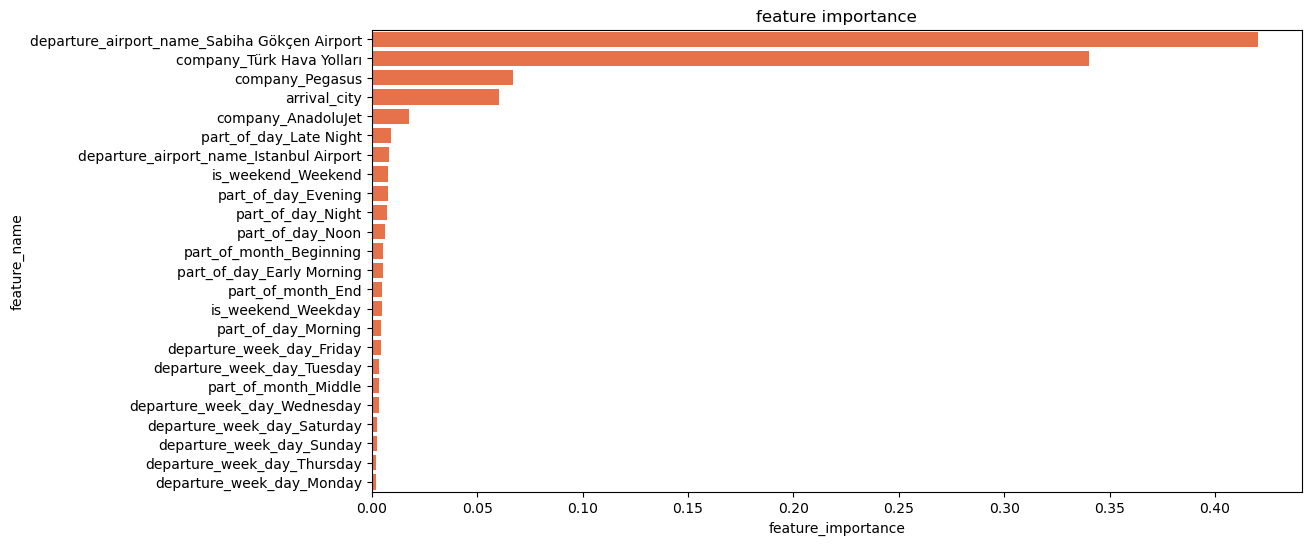

In [17]:
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt,color='#FF6631')
plt.title('feature importance')
plt.show()